        /* GETS ALL :  26Go proceceed */

        #standardSQL

        SELECT
          root.publication_number,
          publication_date,
          root.title_localized,
          root.cpc,
          root.citation
        FROM
          `patents-public-data.patents.publications` root,
          UNNEST( cpc ) AS cpc
        WHERE 
         cpc.code like 'A45D29/02' and
         country_code = 'US'
        LIMIT
          1000
          
          

## Chargement des données 

In [40]:
import json

In [41]:
# load the data
file_path = './data/results-getsAll_20171119-115135.json'

data_brut = []
with open(file_path) as f:
    for line in f:
        entry = json.loads(line)
        data_brut.append( entry )

## Pre-process

In [42]:
# permet de filtrer sur les plus anciens brevets, pour le debug
data_brut_sort = sorted( data_brut, key=lambda d: d['publication_date']  )
N = 160

In [43]:
data_brut_sort[16]

{'citation': [],
 'cpc': [{'code': 'A45D29/02',
   'first': 'true',
   'inventive': 'true',
   'tree': []}],
 'publication_date': '18961020',
 'publication_number': 'US-569903-A',
 'title_localized': [{'language': 'en', 'text': 'winger'}]}

In [52]:
data = {}

for entry in data_brut_sort[:N]:
    
    pubnum = entry['publication_number']
    if pubnum in data: # supprime les doublons
        continue

    new_entry = {}
    new_entry['year'] = int(  entry['publication_date'][0:4] )
    
    new_entry['month'] = int( entry['publication_date'][4:6] )
    new_entry['day'] = int(   entry['publication_date'][6:]  )
    
    new_entry['date_str'] = entry['publication_date']

    new_entry['title'] = entry['title_localized'][0]['text']
    
    new_entry['citation'] = [ c['publication_number'] for c in entry['citation'] ]
    new_entry['citation_cat'] = [ c['category'] for c in entry['citation'] ]

    new_entry['cpc'] = entry['cpc']
    
    data[ pubnum ] = new_entry
    
print(len(data))

160


In [46]:
list( data.values() )[0]

{'citation': [],
 'citation_cat': [],
 'cpc': [{'code': 'A45D29/02',
   'first': 'true',
   'inventive': 'true',
   'tree': []}],
 'date_str': '19161114',
 'day': 14,
 'month': 11,
 'title': 'Toilet-scissors.',
 'year': 1916}

# Construire le graph des citations

En utilisant la librairie [graph-tool](https://graph-tool.skewed.de/).

In [20]:
import graph_tool.all as gt

In [21]:
# create graph
g = gt.Graph()

# add vertex property
label_prop = g.new_vertex_property("string")
g.vp.label = label_prop 

label_prop = g.new_vertex_property("int")
g.vp.year = label_prop 

In [22]:
# Ajoute les vertex
for pub_number, entry in data.items():
    
    entry['vertex'] = g.add_vertex()
    
    g.vp.label[ entry['vertex'] ] = pub_number
    g.vp.year[ entry['vertex'] ] = entry['year']
    
print( g.num_vertices()  )

160


In [23]:
# debug
i = 5
v  = list(data.values())[i]['vertex']
g.vp.label[v]

'US-3316634-A'

In [24]:
# ajoute les arretes (citations)
for pub_number, entry in data.items():
    
    # la fleche est dans le sens du temps...
    target = entry['vertex']
    
    for citation_number in entry['citation']:
        if citation_number in data:
            source  = data[citation_number]['vertex']
            
            e = g.add_edge(source, target)
            
print( g.num_edges()  )

112


In [25]:
# Garde seulement la composante principale:

largest_comp = gt.label_largest_component(g, directed=False)

del_list = [ v for v in g.vertices() if not largest_comp[v]  ]

# 'del_list' is a list of vertex descriptors
# Voir https://graph-tool.skewed.de/static/doc/graph_tool.html?highlight=remove#graph_tool.Graph.remove_vertex

for v in reversed(sorted(del_list)):
    g.remove_vertex(v)
    
print( g.num_vertices()  )
print( g.num_edges()  )

68
103


In [26]:
g.save('citation_graph.graphml')

In [27]:
# draw
# gt.graph_draw(g, #vertex_text=g.vertex_index, vertex_font_size=18,
# ...            output_size=(1400, 1400), output="graph.png")

# Look categories

In [201]:
code_used = dict()
code_used_subset = dict()

for pub_number, entry in data.items():
    
    codes = [ cpc['code'] for cpc in entry['cpc'] ]
    
    codes_subset = [ c[:4] for c in codes ]
    
    #code_used = code_used.union(codes)
    
    # count
    for c in codes:
        if c in code_used:
            code_used[c] += 1
        else:
            code_used[c] = 1

In [358]:
print( sorted( code_used.items(), key=lambda x:x[1], reverse=True )[:8] )

[('A45D29/02', 408), ('A01K13/00', 28), ('A45D29/18', 24), ('A45D29/04', 18), ('A45D2029/026', 17), ('A01K17/00', 15), ('A45D29/023', 14), ('B26B17/02', 13)]


cpc code definition https://www.uspto.gov/web/patents/classification/cpc/html/defA45D.html#A45D29/18

* ('A01K13/00', 28): Devices for grooming or caring of animals
* Subclass A01K: ANIMAL HUSBANDRY; CARE OF BIRds..


* ('A45D29/18', 24): Manicure or pedicure sets
* ('A45D29/04', 18): Nail files, e.g. manually operated   (lime à ongle)
* A45D 29/023: {with retainers for nail clippings}

In [204]:
# lien automatique vers def.
code = list( code_used )[3]
print( code )

lien = 'https://www.uspto.gov/web/patents/classification/cpc/html/def{0}.html#{1}'.format( code[:4], code )

print( lien )

Y10T29/53943
https://www.uspto.gov/web/patents/classification/cpc/html/defY10T.html#Y10T29/53943


# Brevets par année

In [496]:
import matplotlib.pyplot as plt
%matplotlib inline

In [497]:
countbyyear = { x:0 for x in range(1870, 2018, 1) }

for pub_number, entry in data.items():
    y = entry['year']
    
    countbyyear[y] += 1

In [498]:
yearsX, countY =  list( zip( *countbyyear.items() ) )

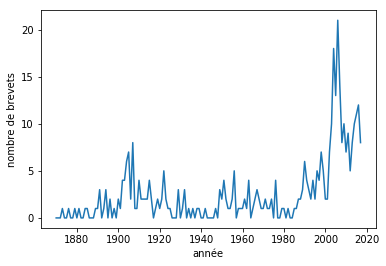

In [500]:
plt.plot( yearsX, countY );  plt.xlabel('année'); plt.ylabel('nombre de brevets');

In [47]:
years = [ (n, p['year']) for n, p in data.items() ]

In [48]:
min(years, key=lambda x:x[1]), max(years, key=lambda x:x[1])

(('US-138061-A', 1873), ('US-2017042307-A1', 2017))

In [49]:
years = sorted( years, key=lambda x:x[1] )

In [50]:
import pickle

In [51]:
pickle.dump( years, open('YearsPatentNumber_ggle.pickle','wb') )

# Ghost citation

def: citations qui apparaissent souvent, mais qui ne sont pas dans le corpus

In [501]:
ghost_citation = {}
citation_count = {}

for pub_number, entry in data.items():
    
    for citation_number in entry['citation']:
        if citation_number not in data:
            
            if citation_number in ghost_citation:
                ghost_citation[citation_number] += 1
            else:
                ghost_citation[citation_number] = 1
                
        else:
            if citation_number in citation_count:
                citation_count[citation_number] += 1
            else:
                citation_count[citation_number] = 1  
            
print(len(ghost_citation), len(citation_count))

1092 255


In [502]:
# Ghost citation
print(sorted( ghost_citation.items(), key=lambda x:x[1], reverse=True )[:20] )

[('', 22), ('US-6220251-B1', 17), ('US-5546658-A', 16), ('US-3744131-A', 16), ('US-3838507-A', 15), ('US-3903596-A', 14), ('US-5392518-A', 14), ('US-6523545-B2', 14), ('US-2955354-A', 13), ('US-4196514-A', 12), ('US-4856190-A', 12), ('US-5617633-A', 11), ('US-4341015-A', 11), ('US-5983498-A', 11), ('US-5640770-A', 11), ('US-4648415-A', 10), ('US-3180025-A', 10), ('US-4614031-A', 9), ('US-5522136-A', 9), ('US-4017923-A', 9)]


In [503]:
# Max citation
print(sorted( citation_count.items(), key=lambda x:x[1], reverse=True )[:20] )

[('US-4176449-A', 19), ('US-6553592-B2', 16), ('US-5384960-A', 15), ('US-4847994-A', 15), ('US-4982747-A', 14), ('US-4228585-A', 13), ('US-3315354-A', 13), ('US-2616436-A', 13), ('US-3042047-A', 13), ('US-4819673-A', 13), ('US-3943948-A', 12), ('US-4644644-A', 12), ('US-2753626-A', 12), ('US-6557259-B1', 12), ('US-5063666-A', 12), ('US-3997966-A', 11), ('US-1394727-A', 11), ('US-5123430-A', 11), ('US-7020964-B2', 11), ('US-796389-A', 10)]


# Graph topology

In [504]:
gt.is_DAG( g )

False

## Retire les circuits

In [505]:
# retire les circuits :
for circuit in gt.all_circuits( g, unique=True ) :
    print( "> ", circuit  )
    print(  ', '.join( [ g.vp.label[v] for v in circuit ]  ))
    print(  ', '.join( [ str(g.vp.year[v]) for v in circuit ]  ))
    
    chronologique = sorted( [ v for v in circuit ], key=lambda v:g.vp.year[v] ) 
    print( 'ordered', chronologique )
    edge = g.edge( *chronologique )
    g.remove_edge( edge )
    
gt.is_DAG( g )

>  [53 64]
US-2013212884-A1, US-2011154667-A1
2013, 2011
ordered [64, 53]
>  [116 273]
US-2008148572-A1, US-2009223055-A1
2008, 2009
ordered [116, 273]


True

## Vertex sans brevet citant / sans descendant

In [686]:
end_vertex = []

for v in g.vertices():
    
    if v.out_degree() == 0:
        end_vertex.append( v )
        
print( len( end_vertex ) )

12


In [687]:
# verif
# data[ g.vp.label[ end_vertex[5] ] ], g.vp.label[ end_vertex[5] ]

## Vertex sans citations:

In [688]:
start_vertex = []

for v in g.vertices():
    
    if v.in_degree() == 0:
        start_vertex.append( v )
        
print( len( start_vertex ) )

20


# L'ensemble des ancêtres :

In [689]:
ancestors_stock = dict()

def find_ancestors( v, ancestors = set() ):
    if v in ancestors_stock:
        ancestors = ancestors_stock[v]
    else:
        for u in v.in_neighbors():
            ancestors.add(u)
            A = find_ancestors( u, ancestors = ancestors )
            ancestors = ancestors.union( A )
        ancestors_stock[v] = ancestors
        
    return ancestors

In [690]:
# test
v = end_vertex[30]

ancestors = find_ancestors( v )
print( len( ancestors ) )

IndexError: list index out of range

In [691]:
def find_descendants( v, descendants = set() ):
    for u in v.out_neighbors():
        descendants.add(u)
        A = find_descendants( u, descendants = descendants )
        descendants = descendants.union( A )
    return descendants

In [692]:
# test
v = start_vertex[11]

descendants = find_descendants( v )
print( len( descendants ) )

2


## Plus proche commun ancêtre

non unique

In [693]:
def find_common_ancestors( u, v ):
    ancestors_u = find_ancestors( u )
    ancestors_v = find_ancestors( v )

    common_vertex = ancestors_u & ancestors_v

    # cherche les vertex qui n'ont pas de descendance dans les vertex commun
    PCA = []
    for a in common_vertex:

        out = set( a.out_neighbors() ) 

        if len( common_vertex.intersection( out ) ) == 0:
            PCA.append( a )

    return  PCA 

In [694]:
u = g.vertex( end_vertex[14] )
v = g.vertex( end_vertex[40] )

print( find_common_ancestors( u, v )  )

IndexError: list index out of range

# Quel brevet genère le plus le graph ?

In [695]:
n_descendance = []

for index in start_vertex:
    D = find_descendants( g.vertex(index) )
    n_descendance.append( len(D) )

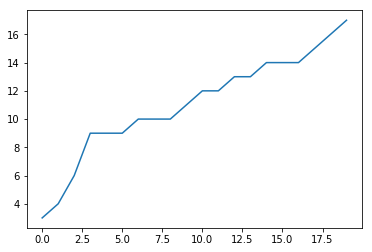

In [696]:
plt.plot( sorted( n_descendance ) )

In [697]:
n_ancetres = []

for index in end_vertex:
    A = find_ancestors( g.vertex(index) )
    n_ancetres.append( len(A) )

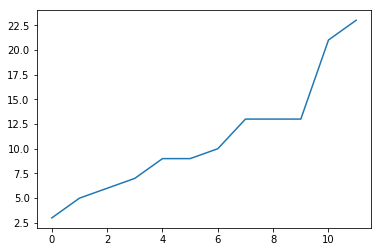

In [698]:
plt.plot( sorted( n_ancetres ) )

In [28]:
gt.graphviz_draw(g,  size=(15, 15), layout='dot', output="graphviz-draw.svg", vsize=1.0, \
             gprops={'rankdir':'LR'}, penwidth=10, vprops={'shape':'box'})

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f5c88012390, at 0x7f5c892bd6a0>

## Get image ?

In [594]:
import urllib.request

In [615]:
'''for pat_pubnumber in list(data.keys())[50:70]:
    
    filename = 'images/%s-%s.png' % ( str(data[pat_pubnumber]['year']) , str(pat_pubnumber) )
    parts = pat_pubnumber.split('-')
    
    #   http://patentimages.storage.googleapis.com/pages/US5524344-1.png
    formated_number1 = ''.join(parts[0:2])
    url1 = 'http://patentimages.storage.googleapis.com/pages/%s-1.png' % formated_number1

    try:
        local_filename, headers = urllib.request.urlretrieve(url1, filename)
        print( local_filename )
        
    except urllib.error.HTTPError as err:
        print('http error', err.code, pat_pubnumber)
        
'''

"for pat_pubnumber in list(data.keys())[50:70]:\n    \n    filename = 'images/%s-%s.png' % ( str(data[pat_pubnumber]['year']) , str(pat_pubnumber) )\n    parts = pat_pubnumber.split('-')\n    \n    #   http://patentimages.storage.googleapis.com/pages/US5524344-1.png\n    formated_number1 = ''.join(parts[0:2])\n    url1 = 'http://patentimages.storage.googleapis.com/pages/%s-1.png' % formated_number1\n\n    try:\n        local_filename, headers = urllib.request.urlretrieve(url1, filename)\n        print( local_filename )\n        \n    except urllib.error.HTTPError as err:\n        print('http error', err.code, pat_pubnumber)\n        \n"

#### pour les images individuels - ne marche pas :
```python
        # https://patentimages.storage.googleapis.com/US20140014042A1/US20140014042A1-20140116-D00001.png    
        formated_number2 = ''.join(parts)
        url2 = 'https://patentimages.storage.googleapis.com/{0}/{0}-{1}-D00000.png'.format(formated_number2, data[pat_pubnumber]['date_str'] )

        try:
            local_filename, headers = urllib.request.urlretrieve(url2, filename)
            print( local_filename, "*" )
            
        except urllib.error.HTTPError as err:
```